In [1]:
# This notebook illustrates how, in principle, a TimeDelayAdjustLens
# instance could be used to adjust the time delay for a particular
# image.

In [2]:
# Start loading some modules and setting some defaults
%matplotlib inline
import grale.lenses as lenses
import grale.images as images
import grale.plotutil as plotutil
import grale.cosmology as cosmology
import grale.feedback as feedback
import grale.renderers as renderers
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt

V = lambda x,y: np.array([x,y],dtype=np.double)

cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)
renderers.setDefaultLensPlaneRenderer("openmp")
renderers.setDefaultMassRenderer("openmp")
feedback.setDefaultFeedback("none")

In [3]:
# We'll construct a lens with a Plummer mass density
zd, zs = 0.5, 2.0
Dd = cosm.getAngularDiameterDistance(zd)
Ds = cosm.getAngularDiameterDistance(zs)
Dds = cosm.getAngularDiameterDistance(zd, zs)
l = lenses.PlummerLens(Dd, { "mass": 1e14*MASS_SUN, "width": 5*ANGLE_ARCSEC})

In [4]:
# We'll (ab)use the plotImagePlane function to calculate the image plane for this
# lens.
lensInfo = { 
    "lens": l, 
    "bottomleft": -V(40,40)*ANGLE_ARCSEC,
    "topright": V(40,40)*ANGLE_ARCSEC,
    "Ds": Ds,
    "Dds": Dds
}
# We'll do the calculations, but not plot the result at this point by setting axes=False
lensInfo = plotutil.plotImagePlane(l, axes=False);

In [5]:
# Get the image plane, and calculate where the images of a source at (5",2") appear
ip = lensInfo["imageplane"]

beta = V(5,2)*ANGLE_ARCSEC
thetas = np.array(ip.traceBeta(beta))
thetas/ANGLE_ARCSEC

array([[-20.67346846,  -8.26938738],
       [ -0.20144651,  -0.0805786 ],
       [ 25.87491497,  10.34996599]])

In [6]:
# Get the time delays for these images
tds = l.getTimeDelay(zd, lensInfo["Ds"], lensInfo["Dds"], thetas, beta)/(60*60*24*365)
tds = tds - tds.min()
tds

array([ 38.97785472, 128.03271462,   0.        ])

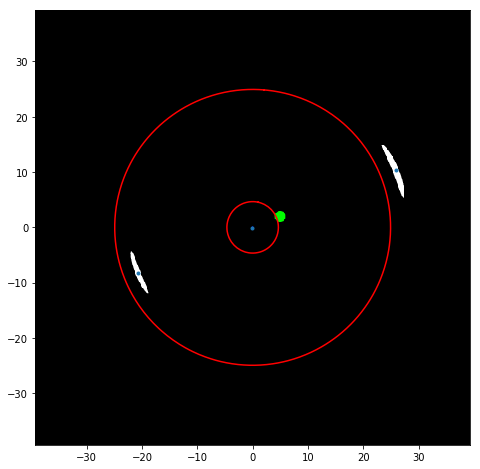

In [7]:
# Create a plot, also using a more extended source shape
src = images.CircularSource(beta, 1.0*ANGLE_ARCSEC)

plt.figure(figsize=(8,8))
lensInfo = plotutil.plotImagePlane(lensInfo, [src])
plt.plot(thetas[:,0]/ANGLE_ARCSEC, thetas[:,1]/ANGLE_ARCSEC, '.');

In [8]:
# Now, let's create a circularly symmetric lens with which we can adjust the time delay. 
# We're going to add this lens to the previous one, at the position of the leftmost image
tdLens = lenses.TimeDelayAdjustLens(l.getLensDistance(), {
    "z": zd,
    # This is the effect on the time delay at the central location
    "dt": 60*60*24*365*1,
    # Below this radius, the time delay will be modified by the amount above
    "theta1": 1*ANGLE_ARCSEC,
    # Beyond this radius there won't be any effect on the time delay anymore
    "theta2": 20*ANGLE_ARCSEC
})

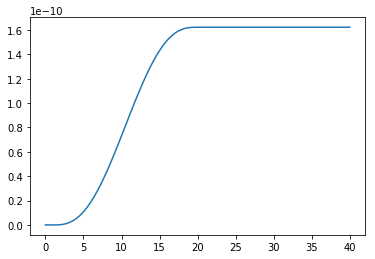

In [9]:
# Plot the lens potential from the center of the lens to 40"
# We'll vary the x-coord for this, and set the y-coord to 0
pthetas = np.empty((100,2))
pthetas[:,0], pthetas[:,1] = np.linspace(0, 40*ANGLE_ARCSEC, 100), 0

# Obtain the potential values at these points, and plot them. As you'll see,
# below 1" and beyond 20", the lens potential will be constant. In these regions,
# there will be no effect on the deflection or the magnification, but the
# difference in potential value does cause a difference in time delay
phi = tdLens.getProjectedPotential(lensInfo["Ds"], lensInfo["Dds"], pthetas)
plt.plot(pthetas[:,0]/ANGLE_ARCSEC, phi);

In [10]:
tdLensInfo = { "lens": tdLens, "bottomleft": lensInfo["bottomleft"], "topright": lensInfo["topright"]}

In [11]:
# In the region between theta1 and theta2, the projected density will vary, as the
# plot shows
plotutil.plotDensityInteractive(tdLensInfo);

In [12]:
# Now, let's add that new part to the original lens
compLens = lenses.CompositeLens(l.getLensDistance(), [
    { "x":0, "y": 0, "factor": 1, "angle": 0, "lens": l },
    { "x": thetas[0,0], "y": thetas[0,1], "factor": 1, "angle": 0, "lens": tdLens }
])

In [13]:
compLensInfo = { "lens": compLens, "bottomleft": lensInfo["bottomleft"], "topright": lensInfo["topright"],
                 "Ds": lensInfo["Ds"], "Dds": lensInfo["Dds"]}

In [14]:
# Plotting the density does not show the added component clearly, the difference
# is rather small
plotutil.plotDensityInteractive(compLensInfo);

In [15]:
# For this new composite lens, we can also calculate the image plane and
# verify that the same sources are still being generated: the difference
# in image positions is 0
plotutil.plotImagePlane(compLensInfo, axes=False)
thetas2 = np.array(compLensInfo["imageplane"].traceBeta(beta))
thetas/ANGLE_ARCSEC - thetas2/ANGLE_ARCSEC

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

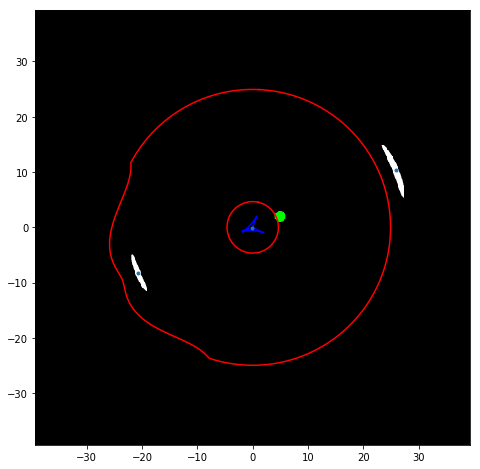

In [16]:
# We do see an effect on the critical lines, which is expected as the
# lens in fact did change.
plt.figure(figsize=(8,8))
plotutil.plotImagePlane(compLensInfo, [src]);
plt.plot(thetas2[:,0]/ANGLE_ARCSEC, thetas2[:,1]/ANGLE_ARCSEC, '.');

In [17]:
# Calculate the time delays again for the new lens and check that the difference is indeed
# 1 year
tds2 = compLens.getTimeDelay(zd, lensInfo["Ds"], lensInfo["Dds"], thetas2, beta)/(60*60*24*365)
tds2 = tds2 - tds2.min()
print("Original time delays:", tds, "(years)")
print("New time delays:     ", tds2, "(years)")
print("Difference:          ", tds2-tds)

Original time delays: [ 38.97785472 128.03271462   0.        ] (years)
New time delays:      [ 39.97785472 128.03271462   0.        ] (years)
Difference:           [1. 0. 0.]
